In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from jax import jit, grad, vmap
import matplotlib.pyplot as plt
import qcsys as qs
import jax.numpy as jnp
from rar_helpers import *

In [3]:
import jaxquantum as jqt

# Linear System

In [4]:
# Analytic calculation of relevant metrics
ϕ0, metrics0, system0 = get_metrics_linear_rar({})
metrics0

{'ω_ResonatorA': Array(4.99584201, dtype=float64),
 'ω_ATS': Array(6.02181564, dtype=float64),
 'ω_ResonatorB': Array(7.00151547, dtype=float64),
 'g_ex': Array(-0.00212182+0.j, dtype=complex128),
 'g_3': Array(1.28654004e-05+0.j, dtype=complex128),
 'g_cd': Array(2.57308009e-05+0.j, dtype=complex128)}

In [5]:
# Calculate Kerr in full system
metrics, system, ϕ0, metrics0, system0 = get_metrics_normal_rar({})#{"ResonatorA_frequency": 3})
metrics["K_a"]*1e9

Array([-1.77635684e-06,  0.00000000e+00,  3.55271368e-06, -3.55271368e-06,
       -3.55271368e-06,  1.42108547e-05], dtype=float64)

In [6]:
# Calculate Kerr in full system
metrics, system, ϕ0, metrics0, system0 = get_metrics_normal_rar({})#{"ResonatorA_frequency": 3})
metrics["K_a"]*1e9

Array([-1.77635684e-06,  0.00000000e+00,  3.55271368e-06, -3.55271368e-06,
       -3.55271368e-06,  1.42108547e-05], dtype=float64)

In [7]:
# Can override parameters!
metrics, system, ϕ0, metrics0, system0 = get_metrics_normal_rar({
    "ATS__dE_J": 37.0 * 0.01
})
metrics["K_a"]*1e9

Array([ 9.07348863e+00,  9.07284203e+00,  9.07206754e+00,  9.07085607e+00,
       -1.22036106e+01,  4.27481506e+05], dtype=float64)

In [8]:
# Can override parameters!
metrics, system, ϕ0, metrics0, system0 = get_metrics_normal_rar({
    "ATS__dE_J": 37.0 * 0.01
})
metrics["K_a"]*1e9

Array([ 9.07348863e+00,  9.07284203e+00,  9.07206754e+00,  9.07085607e+00,
       -1.22036106e+01,  4.27481506e+05], dtype=float64)

# Relevant Hamiltonian Terms for a Time Dep Simulation

In [4]:
metrics, system, ϕ0, metrics0, system0 = get_metrics_normal_rar({
    "ATS__phi_sum_ext": 0.25,
    "ATS__phi_delta_ext": 0.25,
})

In [5]:
H_full = system.get_H()

phi_op = system.params["phi"] 
a_op = system.params["a"]
b_op = system.params["b"]
c_op = system.params["c"]

phi_sum = system.devices[1].params["phi_sum_ext"]
phi_delta = system.devices[1].params["phi_delta_ext"]
ATS_Ej = system.devices[1].params["Ej"]
ATS_dEj = system.devices[1].params["dEj"]
ATS_Ej2 = system.devices[1].params["Ej2"]

omega_a = metrics0["ω_ResonatorA"]
omega_b = metrics0["ω_ResonatorB"]
omega_c = metrics0["ω_ATS"]

H_rot = omega_a * a_op.dag() * a_op + omega_b * b_op.dag() * b_op 
H_static = H_full - qs.ATS.get_H_nonlinear_static(phi_op, ATS_Ej, ATS_dEj, ATS_Ej2, phi_sum, phi_delta)

In [6]:
# Sanity Check (at the right bias point)
H_static_expected = omega_a * a_op.dag() * a_op + omega_b * b_op.dag() * b_op + omega_c * c_op.dag() * c_op
constant_offset = (9.009586565491253) * jqt.identity_like(H_rot)
jnp.max(jnp.abs((H_static - H_static_expected - constant_offset).data))

Array(2.30926389e-14, dtype=float64)

In [7]:
phi = system.params["phi"]
Ejb = system.devices[1].params["Ej"]
H_drive_factor = -2*Ejb*jqt.sinm(phi) # only valid at the (phi_sum,phi_delta) = (0.25,0.25) bias point

In [8]:
# The full system Hamiltonian H = H_static + sin(eps(t)) * H_drive_factor
H_rot_qt = jqt.jqt2qt(H_rot)
H_static_qt = jqt.jqt2qt(H_static)
H_drive_factor_qt = jqt.jqt2qt(H_drive_factor) 

# Run Sweep

### Calculate Metrics

In [9]:
def sweep_function(ATS__E_J):
    ϕ0, metrics0, system0 = get_metrics_linear_rar({
        "ResonatorA_frequency": 5,
        "ResonatorB_frequency": 7,
        "ATS__E_J": ATS__E_J
    })
    metrics = {
        "g_3": metrics0["g_3"],
        "g_cd": metrics0["g_cd"],
    }
    return metrics 

sweep_vmap_function = jit(vmap(sweep_function)) # always jit after vmap, never vmap a jitted function (it'll be slower!)

In [10]:
ATS_Ejs = jnp.linspace(10,50, 101)
metrics = sweep_vmap_function(ATS_Ejs)

/opt/miniconda3/envs/qcsys-error-env/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/miniconda3/envs/qcsys-error-env/lib/python3.12/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0, 0.5, 'Interaction Strengths (kHz)')

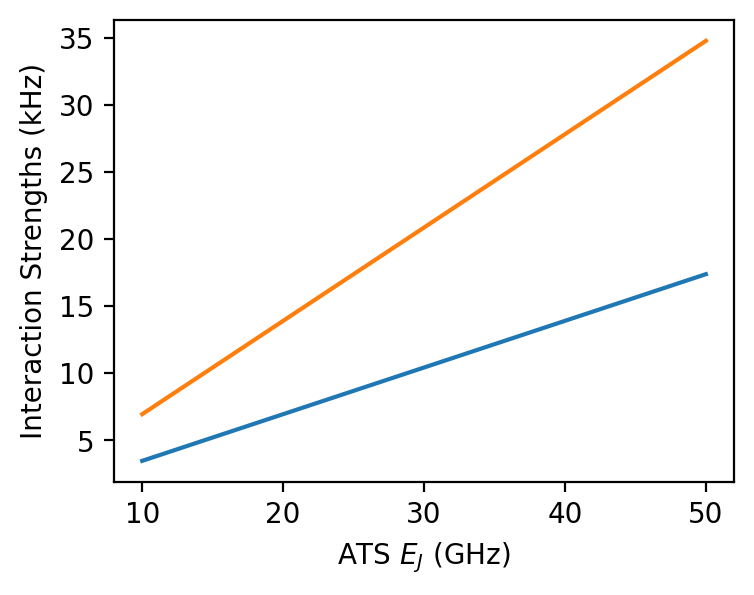

In [11]:
fig, ax = plt.subplots(1,1, dpi=200, figsize=(4,3))
ax.plot(ATS_Ejs, metrics["g_3"]*1e6, label="$g_3$")
ax.plot(ATS_Ejs, metrics["g_cd"]*1e6, label="$g_cd$")
ax.set_xlabel("ATS $E_J$ (GHz)")
ax.set_ylabel("Interaction Strengths (kHz)")

### Calculate Metrics 2D w VMAP

In [9]:
_, base_metrics, _ = get_metrics_linear_rar({
        "ResonatorA_frequency": 5,
        "ResonatorB_frequency": 7,
})

In [10]:
def sweep_function(ATS__E_C, ATS__E_L):
    ϕ0, metrics0, system0 = get_metrics_linear_rar({
        "ResonatorA_frequency": 5,
        "ResonatorB_frequency": 7,
        "ATS__E_C": ATS__E_C,
        "ATS__E_L": ATS__E_L
    })
    metrics = {
        "g_3": metrics0["g_3"],
        "g_cd": metrics0["g_cd"],
        "ω_ATS": metrics0["ω_ATS"],
    }
    return metrics 

sweep_vmap_function_0 = vmap(sweep_function, in_axes=(0, None))
sweep_vmap_function = jit(vmap(sweep_vmap_function_0, in_axes=(None, 0)))

In [19]:
ATS_Ecs = 0.0726*jnp.linspace(0.6,1.4, 41)
ATS_Els = 62.40*jnp.linspace(0.6,1.4, 41)
metrics = sweep_vmap_function(ATS_Ecs, ATS_Els)

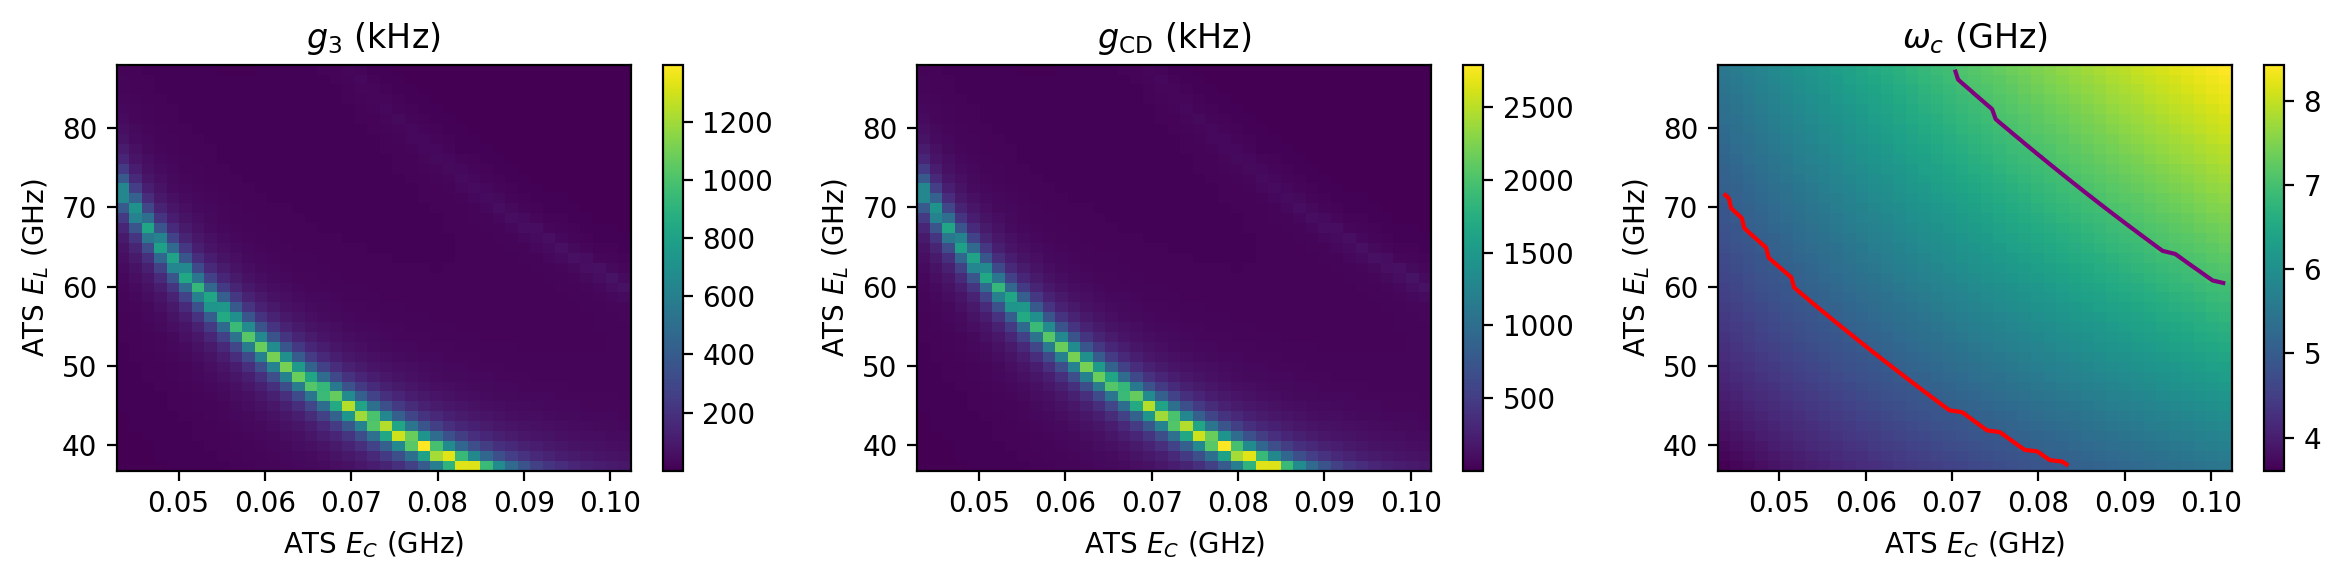

In [24]:
fig, axs = plt.subplots(1,3, dpi=200, figsize=(12,3))

g_3s = jnp.abs(jnp.real(metrics["g_3"]*1e6))
g_cds = jnp.abs(jnp.real(metrics["g_cd"]*1e6))
omega_cs = jnp.abs(jnp.real(metrics["ω_ATS"]))

ax = axs[0]
cax = ax.pcolormesh(ATS_Ecs, ATS_Els, g_3s)
c = fig.colorbar(cax)
ax.set_title(r"$g_3$ (kHz)")
ax.set_xlabel("ATS $E_C$ (GHz)")
ax.set_ylabel("ATS $E_L$ (GHz)")

ax = axs[1]
cax = ax.pcolormesh(ATS_Ecs, ATS_Els, g_cds)
c = fig.colorbar(cax)
ax.set_title(r"$g_{\rm CD}$ (kHz)")
ax.set_xlabel("ATS $E_C$ (GHz)")
ax.set_ylabel("ATS $E_L$ (GHz)")

ax = axs[2]
z = omega_cs
cax = ax.pcolormesh(ATS_Ecs, ATS_Els, z)
ax.contour(ATS_Ecs, ATS_Els, z, levels=[base_metrics["ω_ResonatorA"]], colors="red")
ax.contour(ATS_Ecs, ATS_Els, z, levels=[base_metrics["ω_ResonatorB"]], colors="purple")
c = fig.colorbar(cax)
ax.set_xlabel("ATS $E_C$ (GHz)")
ax.set_ylabel("ATS $E_L$ (GHz)")
ax.set_title(r"$\omega_c$ (GHz)")


fig.tight_layout()

### Calculate Metrics 2D w For Loop and VMAP

In [13]:
def sweep_function(ATS__E_C, ATS__E_L):
    ϕ0, metrics0, system0 = get_metrics_linear_rar({
        "ResonatorA_frequency": 5,
        "ResonatorB_frequency": 7,
        "ATS__E_C": ATS__E_C,
        "ATS__E_L": ATS__E_L
    })
    metrics = {
        "g_3": metrics0["g_3"],
        "g_cd": metrics0["g_cd"],
        "ω_ATS": metrics0["ω_ATS"],
    }
    return metrics 

sweep_vmap_function_0 = vmap(sweep_function, in_axes=(0, None))

In [14]:
ATS_Ecs = 0.0726*jnp.linspace(0.6,1.4, 11)
ATS_Els = 62.40*jnp.linspace(0.6,1.4, 11)
metrics_list = []
for ATS_El_value in ATS_Els: # This option is less memory intensive, but slower than double vmaping. 
    metrics_list.append(sweep_vmap_function_0(ATS_Ecs, ATS_El_value))

In [15]:
g_3s = jnp.array([jnp.abs(jnp.real(metrics["g_3"]*1e6)) for metrics in metrics_list])
g_cds = jnp.array([jnp.abs(jnp.real(metrics["g_cd"]*1e6)) for metrics in metrics_list])
omega_cs = jnp.array([jnp.abs(jnp.real(metrics["ω_ATS"])) for metrics in metrics_list])

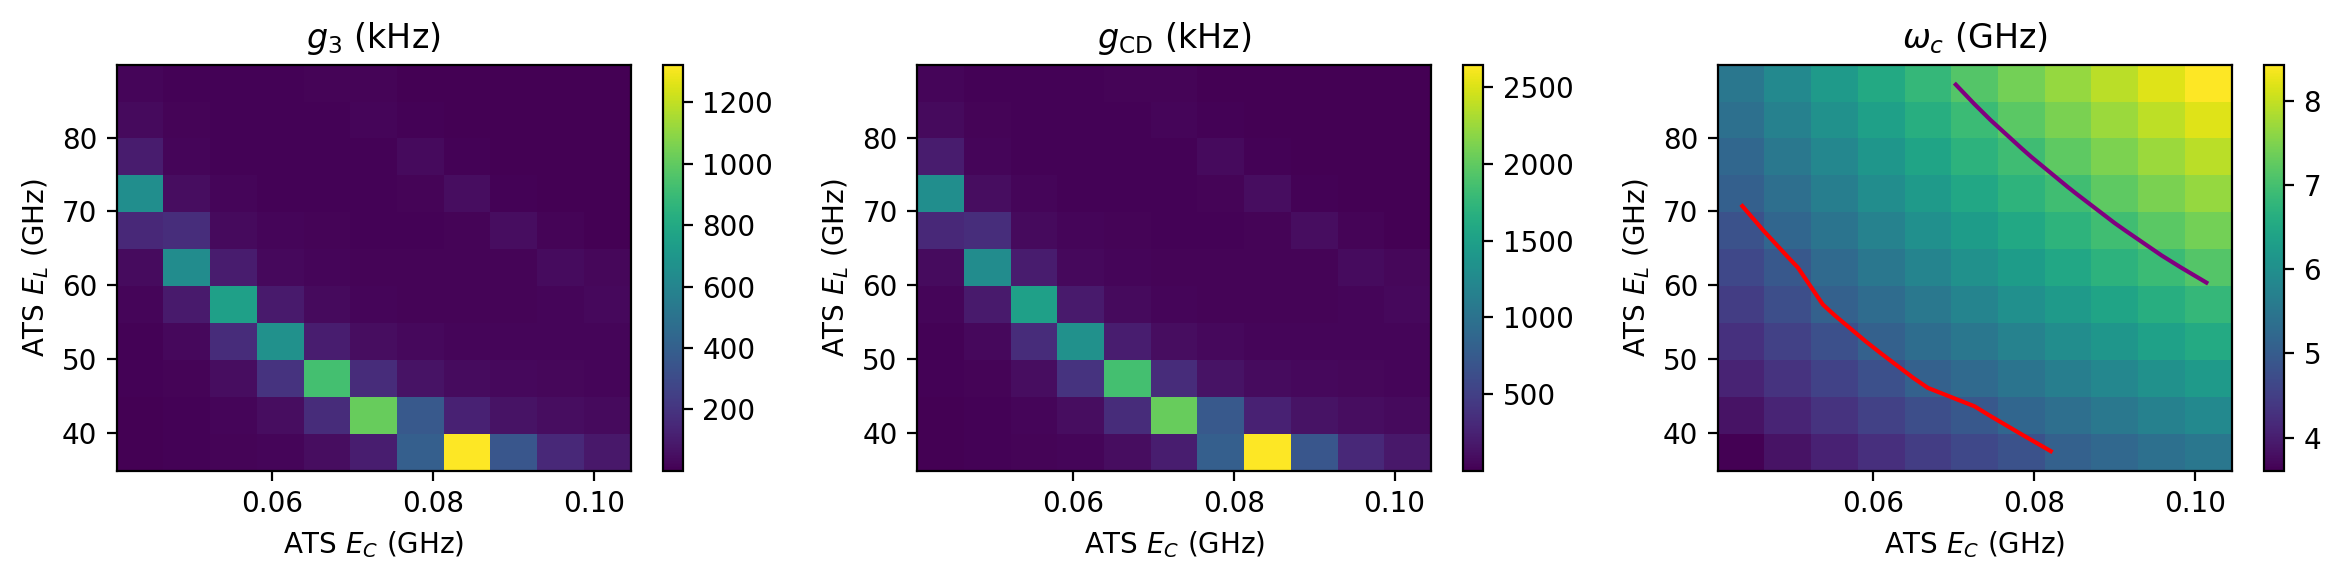

In [18]:
fig, axs = plt.subplots(1,3, dpi=200, figsize=(12,3))

ax = axs[0]
cax = ax.pcolormesh(ATS_Ecs, ATS_Els, g_3s)
ax.set_xlabel("ATS $E_C$ (GHz)")
ax.set_ylabel("ATS $E_L$ (GHz)")
c = fig.colorbar(cax)
ax.set_title(r"$g_3$ (kHz)")

ax = axs[1]
cax = ax.pcolormesh(ATS_Ecs, ATS_Els, g_cds)
ax.set_xlabel("ATS $E_C$ (GHz)")
ax.set_ylabel("ATS $E_L$ (GHz)")
c = fig.colorbar(cax)
ax.set_title(r"$g_{\rm CD}$ (kHz)")

ax = axs[2]
z = omega_cs
cax = ax.pcolormesh(ATS_Ecs, ATS_Els, z)
ax.contour(ATS_Ecs, ATS_Els, z, levels=[base_metrics["ω_ResonatorA"]], colors="red")
ax.contour(ATS_Ecs, ATS_Els, z, levels=[base_metrics["ω_ResonatorB"]], colors="purple")
ax.set_xlabel("ATS $E_C$ (GHz)")
ax.set_ylabel("ATS $E_L$ (GHz)")
c = fig.colorbar(cax)
ax.set_title(r"$\omega_c$ (GHz)")

fig.tight_layout()

### Calculate Kerr

In [17]:
def sweep_function(ATS__E_J):
    metrics, system, ϕ0, metrics0, system0 = get_metrics_normal_rar({
        "ResonatorA_frequency": 5,
        "ResonatorB_frequency": 7,
        "ATS__E_J": ATS__E_J
    })
    metrics_return = {
        "K_a": metrics["K_a"][0],
        "K_b": metrics["K_b"][0]
    }
    return metrics_return 

sweep_vmap_function = jit(vmap(sweep_function)) # always jit after vmap, never vmap a jitted function (it'll be slower!)

In [18]:
ATS_Ejs = jnp.linspace(10,50, 11)
metrics = sweep_vmap_function(ATS_Ejs)

Text(0, 0.5, 'Kerr Strengths (Hz)')

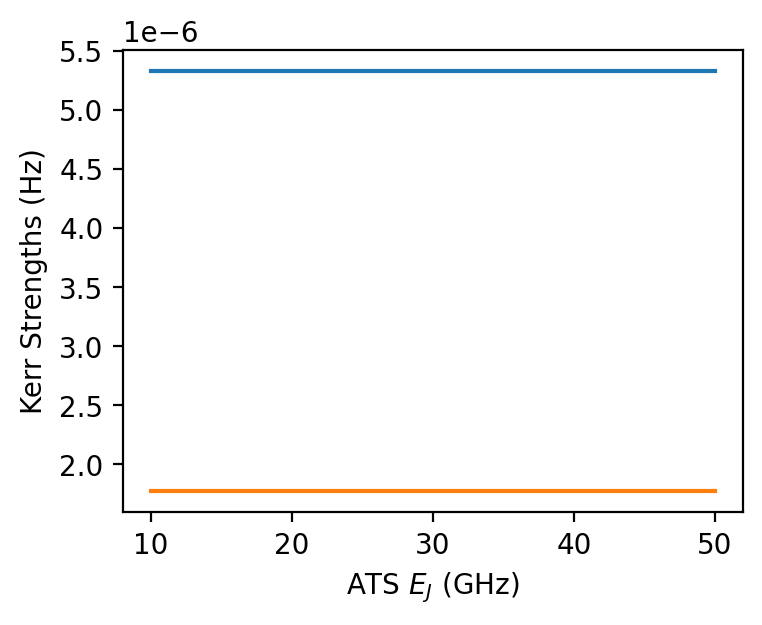

In [21]:
# Near zero Kerr!
fig, ax = plt.subplots(1,1, dpi=200, figsize=(4,3))
ax.plot(ATS_Ejs, metrics["K_a"]*1e9, label="$K_a$")
ax.plot(ATS_Ejs, metrics["K_b"]*1e9, label="$K_b$")
ax.set_xlabel("ATS $E_J$ (GHz)")
ax.set_ylabel("Kerr Strengths (Hz)")